# DSME Bonus Point Assignment I Part A
<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0, released 2020-12-11</div>
For task instructions, refer to the assignment PDF.

* The parts of the code you are to implement are indicated via `# TODO` comments.
* You can use the `# Test code` cells to verify your implementation. However note that these are not the unit tests used for grading.
* Some cells create export file in the `solution/` folder. _Include whole `solution/` folder in your submission_.
* DO NOT CLEAR THE OUTPUT of the notebook you are submitting!

In [4]:
# General imports
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

## Question A1 - Neural Network Class
In this task you will implement the building blocks of a simple neural network class.

For simplicity's sake, this class will only allow feed forward networks.
All individual operations, including activation functions, will be represented as layers in this model.
The abstract `Layer` interface defines three methods:

In [5]:
class Layer:
    def forward(self, x):
        """Forward pass of the layer.
        For convenience, input and output are stored in the layer. 

        Args:
            x: Input for this layer. Shape is (batch_size, num_inputs).

        Returns:
            x: Output of this layer. Shape is (batch_size, num_outputs).
        """
        raise NotImplementedError

    def backward(self, gradient):
        """Backward pass of the layer.
        The incoming gradients are stored in the layer. 

        Args:
            gradient: Incoming gradient from the next layer. Shape is (batch_size, num_outputs).

        Returns:
            gradient: Gradient passed to previous layer. Shape is (batch_size, num_inputs).
        """
        raise NotImplementedError

    def update(self, learn_rate):
        """Perform weight update based on previously stored input and gradients.

        Args:
            learn_rate: Learn rate to use for the update.
        """

### a) Linear Layer

In [6]:
class LinearLayer(Layer):
    def __init__(self, input_dim, output_dim, seed=None):
        """Initialize the layer with random weights."""
        # Initialize weights with the He initializer
        rnd = np.random.RandomState(seed).randn(input_dim, output_dim)
        self.w = rnd * (2 / input_dim) 
        
        # Initialize bias with zeros
        self.b = np.zeros(output_dim)
        
        
    def forward(self, x):
        """Forward pass of the layer."""
        self.input = x # Store input
           
        # ********************
        # TODO Compute output
        # x = ...
        
        x = np.matmul(x,self.w)+self.b
        
        # ********************
        
        self.output = x # Store output
        return x
    
    def backward(self, gradient):
        """Backward pass of the layer."""
        self.gradient = gradient # Store incoming gradient
        
        # ********************
        # TODO Apply transfer gradient
        # gradient = ...
        gradient = gradient @ np.transpose(self.w)
        
        # ********************
        
        return gradient
    
    def update(self, learn_rate): #gradient hinzugefügt
        """Perform weight update"""
        
        # ********************
        # TODO Update weights and bias
        # self.W = ...
        # self.b = ...

        self.w = self.w - learn_rate * (np.transpose(self.input) @ self.gradient)
        self.b = self.b - learn_rate * np.sum(self.gradient, axis = 0)
        
        # ********************

In [7]:
## Test code
_test_layer = LinearLayer(4, 5, seed=42)

# Test forward pass
np.testing.assert_array_almost_equal(_test_layer.forward(np.ones((1, 4))), [[-0.38156401, -0.01880618,  0.98566644, -0.88387442, -1.41440743]])

# Test backward pass
np.testing.assert_array_almost_equal(_test_layer.backward(np.ones((1, 5))), [[1.147507,  1.092798, -2.162692, -1.7906 ]])

# Test update
_test_layer.update(0.1)
np.testing.assert_array_almost_equal(_test_layer.w, [[ 0.148357, -0.169132,  0.223844,  0.661515, -0.217077], [-0.217068,  0.689606,  0.283717, -0.334737,  0.17128 ], [-0.331709, -0.332865,  0.020981, -1.05664 , -0.962459], [-0.381144, -0.606416,  0.057124, -0.554012, -0.806152]])
np.testing.assert_array_almost_equal(_test_layer.b, [-0.1, -0.1, -0.1, -0.1, -0.1])
"ok"

'ok'

### b) Implementing ReLU

In [8]:
class ReLULayer(Layer):      
    def forward(self, x):
        """Forward pass of the ReLU layer."""
        self.input = x # Store input
        
        # ********************
        # TODO Compute output
        # x = ...
        
        x = np.where(x>0,x,0)
        
        # ********************
        
        self.output = x # Store output
        return x
    
    def backward(self, gradient):
        """Backward pass of the ReLU layer."""
        self.gradient = gradient # Store incoming gradient
        
        # ********************
        # TODO Apply transfer gradient
        # gradient = ...
        
        gradient = np.where(self.input>0,gradient,0)
             
        # ********************
      
        return gradient
    

In [9]:
# Test Code
_test_layer = ReLULayer()

# Test forward pass
np.testing.assert_array_almost_equal(_test_layer.forward(np.arange(5)-2), [0, 0,  0, 1, 2])

# Test backward pass
assert np.array_equal(_test_layer.backward(np.ones(5)), [0, 0, 0, 1, 1]) or np.array_equal(_test_layer.backward(np.ones(5)), [0, 0, 1, 1, 1]), f"backward expected {[0, 0, 1, 1, 1]} or {[0, 0, 0, 1, 1]}, but got {_test_layer.backward(np.ones(5))}"

"ok"

'ok'

### c) Softmax Layer

In [97]:
from typing import List


class SoftmaxLayer(Layer):      
    def forward(self, x):
        """Forward pass of the softmax layer."""
        self.input = x # Store input
        
        # ********************
        # TODO Compute output
        # x = ...

        if type(x) == list:
        
            x = (np.exp(x))/(np.sum(np.exp(x)))
            x_sum = np.sum(x)
            x_nan = np.isnan(x_sum)

            if x_nan == False:
                self.output = x
                return x
            else:
                self.input = [x - max(self.input) for x in self.input] # https://jamesmccaffrey.wordpress.com/2016/03/04/the-max-trick-when-computing-softmax/
                x = (np.exp(self.input))/(np.sum(np.exp(self.input)))
                x = np.nan_to_num(x, nan=1)
                self.output = x
                return x
        
        if type(x) == np.ndarray:

            x = (np.exp(x))/(np.sum(np.exp(x)))
            x_sum = np.sum(x)
            x_nan = np.isnan(x_sum)

            if x_nan == False:
                self.output = x
                return x
            else:
                self.input = self.input - self.input.max() # https://jamesmccaffrey.wordpress.com/2016/03/04/the-max-trick-when-computing-softmax/
                x = (np.exp(self.input))/(np.sum(np.exp(self.input)))
                x = np.nan_to_num(x, nan=1)
                self.output = x
                return x

        
        # ********************

In [103]:
# Test code
_test_layer = SoftmaxLayer()

# Test forward pass
np.testing.assert_array_almost_equal(_test_layer.forward([[1, 1]]), [[0.5, 0.5]])
np.testing.assert_array_almost_equal(_test_layer.forward([1, 2, 3]), [0.09003057, 0.24472847, 0.66524096])
np.testing.assert_array_almost_equal(_test_layer.forward([0, 1, 2]), [0.09003057, 0.24472847, 0.66524096])
np.testing.assert_array_almost_equal(_test_layer.forward([0]), [1])
np.testing.assert_array_almost_equal(_test_layer.forward([0, 10, 100, 1e6]), [0, 0, 0, 1], err_msg="Overflow")

"ok"

[[0.0624652  0.05733553 0.10664408 0.10933068]
 [0.09105667 0.08911853 0.11810281 0.10406036]
 [0.05837914 0.05660079 0.07530398 0.07160223]]


<ipython-input-97-c26ff82a365e>:15: RuntimeWarning: overflow encountered in exp
  x = (np.exp(x))/(np.sum(np.exp(x)))
<ipython-input-97-c26ff82a365e>:15: RuntimeWarning: invalid value encountered in true_divide
  x = (np.exp(x))/(np.sum(np.exp(x)))


'ok'

### Side Note
The assignment was evaluated with another script where numpy arrays where used for the validation. 
Here the formulation of the trick described in the blog have to be formulated different, which is also relevant for the training. Therefore, 
the two different approaches in the code. 

### d) Completing the Network

#Die Batch-Size soll im ForwardFeed nicht berücksichtigt werden, daher kommt ein Dimensionsfehler???

In [104]:
class FeedForwardNet:
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, x):
        """Forwar pass through the entire network."""
        # ********************
        # TODO Compute output
        # x = ...
               
        for layer in self.layers:
            x = layer.forward(x)
       
        # ********************
        return x
    
    def backward(self, gradient):
        """Backward pass through the entire network."""
        # ********************
        # TODO Back propagate gradients through all layers
               
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

        # ********************

    def train(self, x, target, learn_rate):
        """Train one batch."""
        gradient = self.forward(x) - target  # Assumes quadratic loss function
        self.backward(gradient)  # Backprop
        
        # Update weights in all layers
        for layer in self.layers:
            layer.update(learn_rate)
        

In [105]:
# Test Code
_test_net = FeedForwardNet([LinearLayer(4, 10, seed=0),
                      ReLULayer(),
                      LinearLayer(10, 3, seed=1),
                      SoftmaxLayer(),
                     ])
np.testing.assert_array_almost_equal(_test_net.forward([1,2,3,4]), [0.27760362, 0.64002456, 0.08237182])
"ok"

'ok'

## Question A2 - Autoencoder on MNIST
For more information about MNIST, refer to the assignment PDF.

The next cell will download the dataset and show some examples images.

https://gist.github.com/AFAgarap/4f8a8d8edf352271fa06d85ba0361f26


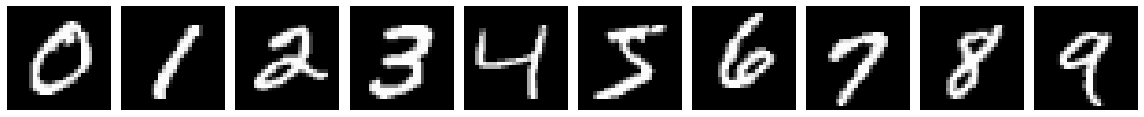

In [106]:
import torch
import torchvision
from torchvision import transforms

# Load MNIST dataset
mnist = torchvision.datasets.MNIST(root='data/', download=True, transform=transforms.ToTensor())
mnist_test = np.array([x.numpy() for x, y in torchvision.datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor())]).reshape(-1, 28, 28)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=32, shuffle=True)

# Show examples
plt.figure(figsize=(16,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    
    # Choose first example with the corresponding digit
    example = next(x for x, y in mnist if y == i).reshape(28, 28)
    plt.imshow(example, cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()

### a) Build the Autoencoder

In [107]:
# TODO Build autoencoder
# autoencoder = FeedForwardNet(...

autoencoder = FeedForwardNet([LinearLayer(784, 256),
                           ReLULayer(),
                           LinearLayer(256, 64),
                           ReLULayer(),
                           LinearLayer(64, 16),
                           LinearLayer(16, 64),
                           ReLULayer(),
                           LinearLayer(64,256),
                           ReLULayer(),
                           LinearLayer(256, 784),
                           ])

In [108]:
# Test Code
assert all(type(l) in [LinearLayer, ReLULayer] for l in autoencoder.layers), "Only use Linear and ReLu layers"
assert autoencoder.layers[0].w.shape[0] == 784, "Wrong size of input"
assert autoencoder.layers[-1].w.shape[1] == 784, "Wrong size of output"
assert min(l.w.shape[0] for l in autoencoder.layers if type(l) == LinearLayer) == 16, "Wrong size of the bottleneck"

"ok"

'ok'

### b) Train the Autoencoder

The next step is to train the autoencoder on the MNIST dataset via minibatch gradient descend.

Implement the training of a batch. 
The incoming batches of images have a shape of (batch_size, 28, 28). To process them in a linear layer, you first need to reshape them to (batch_size, 28 * 28).
Then, use the `train` method of the implemented `FeedForwardNetwork` to train the batch.

Loss 10.16/10.13: 100%|██████████| 25/25 [25:50<00:00, 62.01s/it]


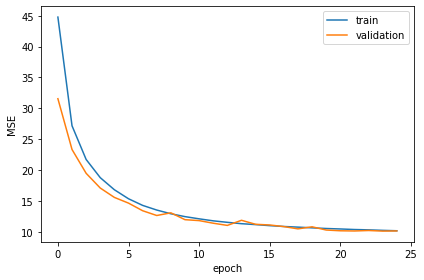

In [109]:
#Hyperparameter
epochs = 25
learn_rate = 0.0008
#batch_size noch anpassen


losses = np.empty((epochs, 2))        #initialisiert (2,2) array
with tqdm(range(epochs)) as pbar:     # stellt nur den Ladebalken dar
    for epoch in pbar:
        running_loss = 0.0
        for batch, _ in data_loader:
            # ********************
            # TODO Reshape and train batch
            # batch =
            
            batch = batch.flatten(start_dim=1)     #flattet den Tensor und mach aus 28,28 28*28
            batch = batch.numpy()[:,:]             #wandelt tensor in numpy array um und behält die Form bei

            autoencoder.train(batch, batch, learn_rate)   #Zielwert ist der Batch, da der Autoencoder diese Bilder wiedergeben soll

            # ********************

            running_loss += np.sum((autoencoder.layers[-1].output - batch)**2)
        
        # Log losses and update progress bar
        train_loss = running_loss/len(mnist)
        validation_loss = np.sum(np.mean((autoencoder.forward(mnist_test.reshape(-1, 28*28))-mnist_test.reshape(-1, 28*28))**2, axis=0))
        losses[epoch] = [train_loss, validation_loss]
        pbar.set_description(f"Loss {train_loss:.02f}/{validation_loss:.02f}")

# Save model
with open("solution/a2b.pickle", "wb") as f:
    pickle.dump(autoencoder, f)

# Visualize losses
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.tight_layout()
plt.savefig("solution/a2b-train.png")

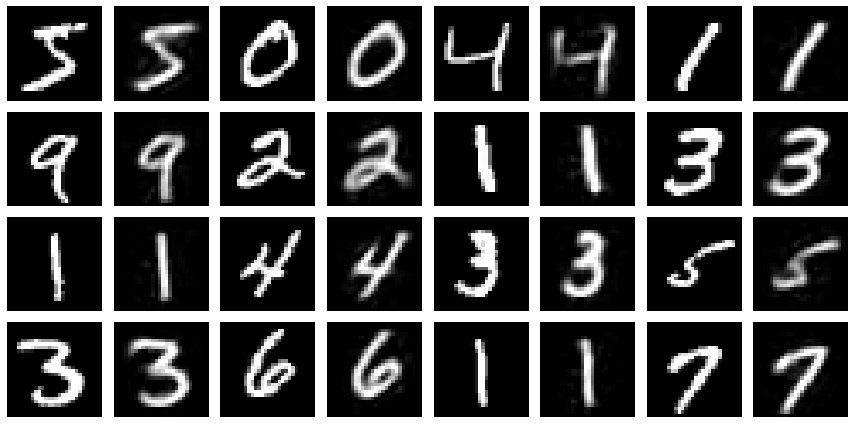

In [110]:
# Show reconstruction
plt.figure(figsize=(12,6))
for i in range(16):
    # Show image
    plt.subplot(4,8,2*i+1)
    plt.imshow(mnist[i][0].reshape((28,28)), cmap="gray")
    plt.axis("off")

    # Show reconstruction
    plt.subplot(4,8, 2*i+2)
    plt.imshow(autoencoder.forward(mnist[i][0].reshape(28*28)).reshape(28,28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()
plt.savefig("solution/a2b-rec.png")

### c) Interpolation

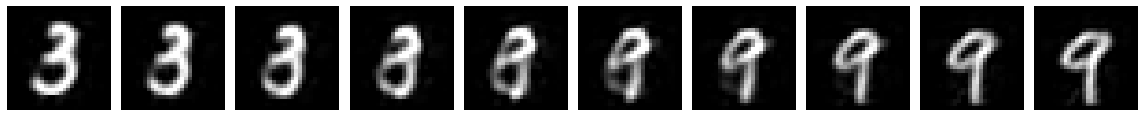

In [115]:
# ********************
# TODO Split the autoencoder at the bottleneck into encoder and decoder 
# encoder = FeedForwardNet(autoencoder.layers[:3])
# decoder = FeedForwardNet(autoencoder.layers[3:])

encoder = FeedForwardNet(autoencoder.layers[:5])
decoder = FeedForwardNet(autoencoder.layers[5:])

# ********************

#  Choose two images 
image_a = mnist[10][0]
image_b = mnist[4][0]

#in Numpy array umwandeln
image_a = image_a.numpy()
image_b = image_b.numpy()

# Compute their latent representations
latent_a = encoder.forward(image_a.reshape(28*28))
latent_b = encoder.forward(image_b.reshape(28*28))

steps=10
plt.figure(figsize=(16,2))
for i, f in enumerate(np.linspace(0, 1, steps)):
    plt.subplot(1, steps, i+1)
    
    # ********************
    # TODO Interpolate between latent_a and latent_b with the mixing factor f
    # latent =

    latent = (1-f)*latent_a+f*latent_b

    # ********************
    
    plt.imshow(decoder.forward(latent).reshape(28, 28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()
plt.savefig("solution/a2c.png")

### d) Latent space sampling

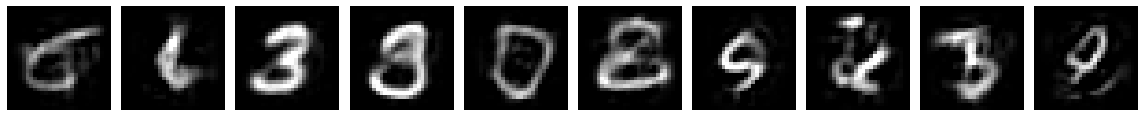

In [116]:
# Compute mean and std of latent states
latent_space = encoder.forward(mnist_test.reshape(-1, 28*28))
latent_space_mean = np.mean(latent_space, axis=0)
latent_space_std = np.std(latent_space, axis=0)

# Sample from latent distribution
plt.figure(figsize=(16,2))
for i, f in enumerate(np.linspace(0,1,steps)):
    plt.subplot(1, steps, i+1)
    
    # ********************
    # TODO Sample from the normal distribution with latent_space_mean and latent_space_std
    # latent =

    latent = np.random.normal(loc = latent_space_mean, scale = latent_space_std)
    
    # ********************
    
    plt.imshow(decoder.forward(latent).reshape(28, 28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()
plt.savefig("solution/a2d.png")